# 3 - Trajectory models

Generative models of individual trajectories

In [1]:
# let's import some useful packages
%matplotlib inline
import skmob
import pandas as pd
import matplotlib.pyplot as plt

## Density EPR
modification of the spatial component of EPR
- movements are made on a spatial tessellation
- it use a *gravity model* in the exploration phase

In [2]:
from skmob.models.epr import DensityEPR

In [3]:
# instantiate a DensityEPR object
depr = DensityEPR()
print(depr)

DensityEPR(name="Density EPR model", rho="0.6", gamma=0.21, tau=17, beta=0.8, min_wait_time=0.3333333333333333)


### Loading a spatial tessellation
- we use a spatial tessellation of Trentino region (Italy)
- each location is a mobile phone tower

In [4]:
from skmob.utils.gislib import load_spatial_tessellation

In [5]:
# let's load a spatial tessellation
spatial_tessellation = load_spatial_tessellation('data/location2info_trentino')
len(spatial_tessellation)

6259

In [6]:
# define the starting and ending time of the simulation
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')

In [7]:
# generate synthetic trajectories for 100 agents  
tdf = depr.generate(start_time, end_time, spatial_tessellation, 
                    n_agents=100, od_matrix=None, show_progress=True)
tdf.head()

100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


,uid,datetime,lat,lng
0,1,2019-01-01 08:00:00.000000,45.875346,10.977951
1,1,2019-01-01 09:22:28.123997,45.875346,10.977951
2,1,2019-01-01 10:24:07.355259,45.848360,10.976994
3,1,2019-01-01 10:50:03.159757,45.857355,10.977313
4,1,2019-01-01 11:35:44.674127,45.857577,10.964439


In [8]:
type(tdf) # it is a TrajDataFrame!

skmob.core.trajectorydataframe.TrajDataFrame

### Details of the generated `TrajDataFrame`

All details of the model are now in the `parameters` attribute

In [9]:
tdf.parameters

{'model': {'class': <function skmob.models.epr.DensityEPR.__init__(self, name='Density EPR model', rho=0.6, gamma=0.21, beta=0.8, tau=17, min_wait_time_minutes=20)>,
  'generate': {'start_date': Timestamp('2019-01-01 08:00:00'),
   'end_date': Timestamp('2019-01-14 08:00:00'),
   'n_agents': 100,
   'starting_location': None,
   'random_state': None,
   'show_progress': True}}}

### Usage Tip! 
If you need to make the simulation several times on the same spatial tessellation but with different parameters you can speed up the computations by pre-computing the *distance matrix* used inside DensityEPR.

The distance matrix contains, for each pair $(i, j)$, the probability of moving from location $i$ to location $j$
$$p_{ij} = O_i m_j f(r_{ij})$$

In [11]:
from skmob.models.epr import compute_od_matrix

In [12]:
od_matrix = compute_od_matrix(spatial_tessellation, use_relevance=True)

100%|██████████| 6259/6259 [01:07<00:00, 92.92it/s]


In [13]:
# generate synthetic trajectories for 100 agents  
tdf = depr.generate(start_time, end_time, spatial_tessellation, 
                    n_agents=100, od_matrix=od_matrix, show_progress=True)
tdf.head()

100%|██████████| 100/100 [00:04<00:00, 20.42it/s]


,uid,datetime,lat,lng
0,1,2019-01-01 08:00:00.000000,46.066376,11.346814
1,1,2019-01-01 09:03:02.875103,46.084890,11.321730
2,1,2019-01-01 10:10:15.669628,45.712984,10.997910
3,1,2019-01-01 10:46:29.202111,45.732512,10.908636
4,1,2019-01-01 11:14:37.354744,45.712984,10.997910


The execution is around 10 times faster!

## Analysis of the generated data
the generated data is a `TrajDataFrame`, this means that:
- we can apply all preprocessing operations
- we can compute all individual and collective measures

In [68]:
from skmob.preprocessing import detection, clustering

In [69]:
stops_tdf = detection.stops(tdf)
stops_tdf.head()

,uid,datetime,lat,lng,leaving_datetime
0,1,2019-01-01 08:00:00.000000,46.066376,11.346814,2019-01-01 09:03:02.875103
1,1,2019-01-01 09:03:02.875103,46.084890,11.321730,2019-01-01 10:10:15.669628
2,1,2019-01-01 10:10:15.669628,45.712984,10.997910,2019-01-01 10:46:29.202111
3,1,2019-01-01 10:46:29.202111,45.732512,10.908636,2019-01-01 11:14:37.354744
4,1,2019-01-01 11:14:37.354744,45.712984,10.997910,2019-01-01 11:57:43.307168


In [70]:
cluster_tdf = clustering.cluster(stops_tdf)
cluster_tdf.head()

,uid,datetime,lat,lng,leaving_datetime,cluster
0,1,2019-01-01 08:00:00.000000,46.066376,11.346814,2019-01-01 09:03:02.875103,3
1,1,2019-01-01 09:03:02.875103,46.084890,11.321730,2019-01-01 10:10:15.669628,5
2,1,2019-01-01 10:10:15.669628,45.712984,10.997910,2019-01-01 10:46:29.202111,2
3,1,2019-01-01 10:46:29.202111,45.732512,10.908636,2019-01-01 11:14:37.354744,0
4,1,2019-01-01 11:14:37.354744,45.712984,10.997910,2019-01-01 11:57:43.307168,2


In [71]:
# visualize the trajectory of a synthetic agent
agent_id = 1
tdf[tdf.uid == agent_id].head()
map_an_agent = tdf[tdf.uid == agent_id].plot_trajectory(hex_color='#666666')
cluster_tdf[cluster_tdf.uid == agent_id].plot_stops(map_f=map_an_agent)

In [72]:
from skmob.measures.individual import uncorrelated_entropy, radius_of_gyration, location_frequency

In [73]:
ue_df = uncorrelated_entropy(tdf)
rg_df = radius_of_gyration(tdf)
ranks = location_frequency(tdf, as_ranks=True)

100%|██████████| 100/100 [00:00<00:00, 315.02it/s]


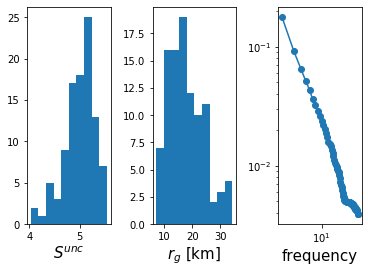

In [74]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(ue_df.uncorrelated_entropy)
ax[0].set_xlabel('$S^{unc}$', fontsize=15)
ax[1].hist(rg_df.radius_of_gyration)
ax[1].set_xlabel('$r_g$ [km]', fontsize=15)
ax[2].plot(range(1, len(ranks) + 1), ranks, marker='o')
ax[2].loglog()
ax[2].set_xlabel('frequency', fontsize=15)
plt.subplots_adjust(wspace=0.5)
plt.show()